In [1]:
import itertools
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# reproducibility (helps but full reproducibility depends on environment)
tf.random.set_seed(0)
np.random.seed(0)

In [4]:
#1) Load & preprocess dataset
# -----------------------------
# Using Fashion MNIST (28x28 grayscale images, 10 classes)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize to [0,1] and keep a small validation split for quick runs
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

In [5]:
# For speed in  demos, you might reduce the training set:
# (uncomment to speed things up)
# x_train = x_train[:20000]; y_train = y_train[:20000]
# x_test  = x_test[:5000];  y_test  = y_test[:5000]


In [6]:
# Add channel dimension: (28,28) -> (28,28,1) for Conv2D compatibility
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

In [7]:
num_classes = 10
input_shape = x_train.shape[1:]  # (28,28,1)

In [8]:
# 2) Model builder (simple, modular)
# -----------------------------
def build_model(num_layers=1,
                num_neurons=128,
                activation='relu',
                dropout_rate=0.0,
                optimizer_name='adam',
                learning_rate=0.001):
    """
    Build a small CNN + dense head. We keep convolutional front small and vary dense head.
    - num_layers: number of Dense hidden layers (after Conv front)
    - num_neurons: neurons in each Dense hidden layer
    - activation: activation function used in hidden layers
    - dropout_rate: dropout applied after each hidden Dense
    - optimizer_name / learning_rate: used at compile time
    """
    model = tf.keras.Sequential()
    # Small convolutional frontend (fixed) to extract features
    model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPool2D(2))
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(2))
    model.add(tf.keras.layers.Flatten())

    # Dense head variable by hyperparameters
    for i in range(num_layers):
        model.add(tf.keras.layers.Dense(num_neurons, activation=activation))
        if dropout_rate and dropout_rate > 0.0:
            model.add(tf.keras.layers.Dropout(dropout_rate))

    # Output layer for classification
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # Select optimizer instance with chosen learning rate
    opt_name = optimizer_name.lower()
    if opt_name == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif opt_name == 'sgd_mom':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif opt_name == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif opt_name == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError("Unknown optimizer: " + optimizer_name)

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [9]:
# -----------------------------
# 3) Hyperparameter grid (small default)
# -----------------------------
# Keep grid small for classroom speed. Expand for experiments.
param_grid = {
    'learning_rate' : [0.1, 0.01, 0.001],      # try coarse values
    'batch_size'    : [64, 256],               # small vs larger batch
    'num_layers'    : [0, 1],                  # 0 = no extra dense hidden layers, 1 = one hidden layer
    'num_neurons'   : [64, 128],               # neurons in hidden layers
    'activation'    : ['relu', 'tanh'],        # compare relu vs tanh
    'optimizer'     : ['sgd', 'sgd_mom', 'adam'], # optimizer choices
    'dropout_rate'  : [0.0, 0.3],              # no dropout vs moderate dropout
    'epochs'        : [8],                     # keep epochs small in demo
}

In [10]:
# Create all combinations (cartesian product)
keys, values = zip(*param_grid.items())
experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(f"Total experiments to run: {len(experiments)}")

Total experiments to run: 288


In [11]:
# Optionally shuffle experiments so different hyperparams show earlier 
np.random.shuffle(experiments)

In [12]:
# 4) Run experiments and record results
# -----------------------------
results = []
start_time = time.time()

for i, params in enumerate(experiments, 1):
    print(f"\n=== Experiment {i}/{len(experiments)} ===")
    print(params)

    # Build model with these hyperparams
    model = build_model(
        num_layers = params['num_layers'],
        num_neurons = params['num_neurons'],
        activation = params['activation'],
        dropout_rate = params['dropout_rate'],
        optimizer_name = params['optimizer'],
        learning_rate = params['learning_rate']
    )


=== Experiment 1/288 ===
{'learning_rate': 0.1, 'batch_size': 256, 'num_layers': 0, 'num_neurons': 64, 'activation': 'tanh', 'optimizer': 'sgd', 'dropout_rate': 0.3, 'epochs': 8}


C:\AI_ML\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Experiment 2/288 ===
{'learning_rate': 0.01, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 128, 'activation': 'relu', 'optimizer': 'sgd_mom', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 3/288 ===
{'learning_rate': 0.1, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 128, 'activation': 'tanh', 'optimizer': 'sgd_mom', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 4/288 ===
{'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 0, 'num_neurons': 128, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 5/288 ===
{'learning_rate': 0.001, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 128, 'activation': 'relu', 'optimizer': 'sgd_mom', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 6/288 ===
{'learning_rate': 0.1, 'batch_size': 64, 'num_layers': 1, 'num_neurons': 128, 'activation': 'tanh', 'optimizer': 'sgd_mom', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 7/288 ===
{'learning_rate': 0.01, 'batch_size': 64, 'num_la


=== Experiment 49/288 ===
{'learning_rate': 0.1, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 64, 'activation': 'relu', 'optimizer': 'sgd_mom', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 50/288 ===
{'learning_rate': 0.001, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 64, 'activation': 'tanh', 'optimizer': 'sgd_mom', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 51/288 ===
{'learning_rate': 0.1, 'batch_size': 256, 'num_layers': 0, 'num_neurons': 64, 'activation': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 52/288 ===
{'learning_rate': 0.001, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 128, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 53/288 ===
{'learning_rate': 0.001, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 64, 'activation': 'tanh', 'optimizer': 'sgd_mom', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 54/288 ===
{'learning_rate': 0.001, 'batch_size': 64, 'num


=== Experiment 95/288 ===
{'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 0, 'num_neurons': 64, 'activation': 'relu', 'optimizer': 'sgd_mom', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 96/288 ===
{'learning_rate': 0.001, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 128, 'activation': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 97/288 ===
{'learning_rate': 0.01, 'batch_size': 256, 'num_layers': 0, 'num_neurons': 64, 'activation': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 98/288 ===
{'learning_rate': 0.1, 'batch_size': 64, 'num_layers': 1, 'num_neurons': 64, 'activation': 'tanh', 'optimizer': 'sgd_mom', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 99/288 ===
{'learning_rate': 0.1, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 64, 'activation': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 100/288 ===
{'learning_rate': 0.01, 'batch_size': 64, 'num_layers'


=== Experiment 140/288 ===
{'learning_rate': 0.1, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 64, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 141/288 ===
{'learning_rate': 0.001, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 64, 'activation': 'relu', 'optimizer': 'sgd_mom', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 142/288 ===
{'learning_rate': 0.001, 'batch_size': 256, 'num_layers': 0, 'num_neurons': 128, 'activation': 'tanh', 'optimizer': 'sgd_mom', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 143/288 ===
{'learning_rate': 0.1, 'batch_size': 64, 'num_layers': 0, 'num_neurons': 128, 'activation': 'tanh', 'optimizer': 'sgd', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 144/288 ===
{'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 1, 'num_neurons': 128, 'activation': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 145/288 ===
{'learning_rate': 0.001, 'batch_size': 64, 'n


=== Experiment 187/288 ===
{'learning_rate': 0.1, 'batch_size': 64, 'num_layers': 0, 'num_neurons': 64, 'activation': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 188/288 ===
{'learning_rate': 0.1, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 128, 'activation': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 189/288 ===
{'learning_rate': 0.1, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 128, 'activation': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 190/288 ===
{'learning_rate': 0.001, 'batch_size': 256, 'num_layers': 0, 'num_neurons': 64, 'activation': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 191/288 ===
{'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 1, 'num_neurons': 64, 'activation': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 192/288 ===
{'learning_rate': 0.1, 'batch_size': 256, 'num_layers'


=== Experiment 233/288 ===
{'learning_rate': 0.01, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 128, 'activation': 'tanh', 'optimizer': 'sgd', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 234/288 ===
{'learning_rate': 0.1, 'batch_size': 64, 'num_layers': 1, 'num_neurons': 128, 'activation': 'tanh', 'optimizer': 'sgd', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 235/288 ===
{'learning_rate': 0.01, 'batch_size': 64, 'num_layers': 0, 'num_neurons': 64, 'activation': 'tanh', 'optimizer': 'sgd_mom', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 236/288 ===
{'learning_rate': 0.01, 'batch_size': 64, 'num_layers': 1, 'num_neurons': 128, 'activation': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 237/288 ===
{'learning_rate': 0.1, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 64, 'activation': 'tanh', 'optimizer': 'sgd', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 238/288 ===
{'learning_rate': 0.1, 'batch_size': 64, 'num_layers': 


=== Experiment 278/288 ===
{'learning_rate': 0.1, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 128, 'activation': 'relu', 'optimizer': 'sgd_mom', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 279/288 ===
{'learning_rate': 0.001, 'batch_size': 256, 'num_layers': 0, 'num_neurons': 64, 'activation': 'relu', 'optimizer': 'sgd_mom', 'dropout_rate': 0.0, 'epochs': 8}

=== Experiment 280/288 ===
{'learning_rate': 0.001, 'batch_size': 256, 'num_layers': 1, 'num_neurons': 128, 'activation': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 281/288 ===
{'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 0, 'num_neurons': 128, 'activation': 'tanh', 'optimizer': 'sgd', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 282/288 ===
{'learning_rate': 0.1, 'batch_size': 64, 'num_layers': 0, 'num_neurons': 64, 'activation': 'tanh', 'optimizer': 'sgd_mom', 'dropout_rate': 0.3, 'epochs': 8}

=== Experiment 283/288 ===
{'learning_rate': 0.001, 'batch_size': 64, 

In [13]:
# Train the model
hist = model.fit(
        x_train, y_train,
        validation_split=0.1,            # small val split for quick feedback
        epochs = params['epochs'],
        batch_size = params['batch_size'],
        verbose = 0                      # set to 1 for per-epoch logs
    )


In [14]:
# Evaluate on test set (fast)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

In [15]:
# Record key metrics and hyperparams
record = {
        **params,
        'train_loss_final': float(hist.history['loss'][-1]),
        'train_acc_final' : float(hist.history['accuracy'][-1]) if 'accuracy' in hist.history else None,
        'val_loss_final'  : float(hist.history['val_loss'][-1]),
        'val_acc_final'   : float(hist.history['val_accuracy'][-1]),
        'test_loss'       : float(test_loss),
        'test_acc'        : float(test_acc),
        'run_time_sec'    : time.time() - start_time
    }
results.append(record)

    # 
print(f"val_acc = {record['val_acc_final']:.4f} ; test_acc = {record['test_acc']:.4f}")


val_acc = 0.8857 ; test_acc = 0.8853


In [16]:
# 5) Save and summarize results
# -----------------------------
df = pd.DataFrame(results)
csv_name = "hp_sweep_results.csv"
df.to_csv(csv_name, index=False)
print(f"\nSaved results to {csv_name}")


Saved results to hp_sweep_results.csv


In [17]:
 #Show top 10 results by val_acc
print("\nTop 10 experiments by validation accuracy:")
print(df.sort_values('val_acc_final', ascending=False).head(10))


Top 10 experiments by validation accuracy:
   learning_rate  batch_size  num_layers  num_neurons activation optimizer  \
0           0.01         256           1           64       relu      adam   

   dropout_rate  epochs  train_loss_final  train_acc_final  val_loss_final  \
0           0.0       8          0.219786         0.917759        0.341061   

   val_acc_final  test_loss  test_acc  run_time_sec  
0       0.885667   0.352388    0.8853    381.245199  


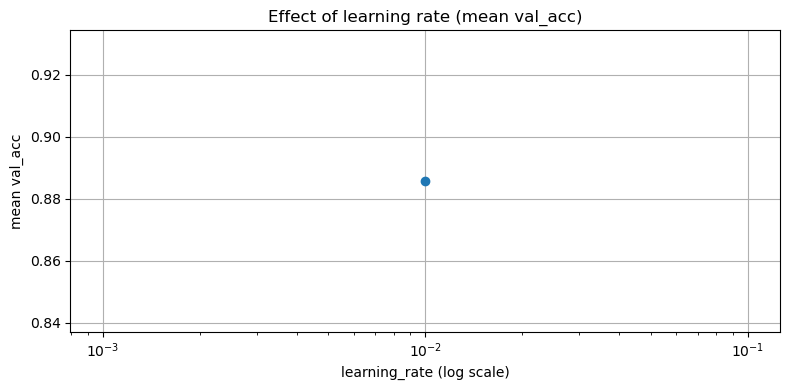

In [18]:
# 6) Plots: effect of important hyperparameters (simple)
# -----------------------------
# Example: plot validation accuracy vs learning rate (aggregate by mean)
plt.figure(figsize=(8,4))
group = df.groupby('learning_rate')['val_acc_final'].mean().reset_index()
plt.plot(group['learning_rate'], group['val_acc_final'], marker='o')
plt.xscale('log')  # learning rate plotted on log scale for clarity
plt.xlabel('learning_rate (log scale)')
plt.ylabel('mean val_acc')
plt.title('Effect of learning rate (mean val_acc)')
plt.grid(True)
plt.tight_layout()
plt.show()

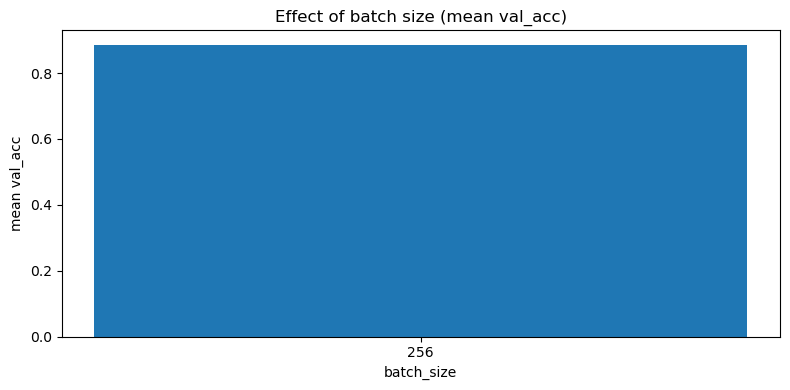

In [19]:
# Effect of batch size
plt.figure(figsize=(8,4))
group = df.groupby('batch_size')['val_acc_final'].mean().reset_index()
plt.bar(group['batch_size'].astype(str), group['val_acc_final'])
plt.xlabel('batch_size')
plt.ylabel('mean val_acc')
plt.title('Effect of batch size (mean val_acc)')
plt.tight_layout()
plt.show()

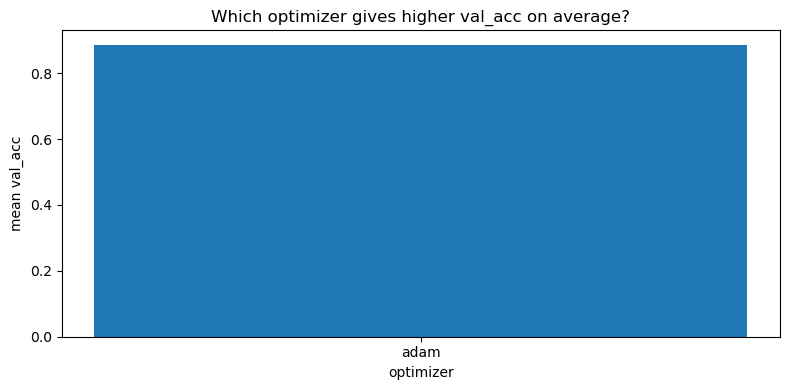

In [20]:
# Compare optimizers
plt.figure(figsize=(8,4))
group = df.groupby('optimizer')['val_acc_final'].mean().reset_index()
plt.bar(group['optimizer'], group['val_acc_final'])
plt.xlabel('optimizer')
plt.ylabel('mean val_acc')
plt.title('Which optimizer gives higher val_acc on average?')
plt.tight_layout()
plt.show()

In [21]:
# Save a short summary CSV grouped by important hyperparams
summary = df.groupby(['optimizer','learning_rate','batch_size'])['val_acc_final'].mean().reset_index()
summary.to_csv("hp_summary_by_opt_lr_bs.csv", index=False)
print("\nSaved grouped summary to hp_summary_by_opt_lr_bs.csv")


Saved grouped summary to hp_summary_by_opt_lr_bs.csv


In [22]:
print("- Learning rate is the most sensitive hyperparameter; check the learning_rate plot.")
print("- Batch size affects stability and generalization; larger batches = faster compute but sometimes worse generalization.")
print("- More layers / neurons can help but may need more data or regularization (dropout).")
print("- Activation: ReLU usually trains faster; tanh can still be useful for small nets.")
print("- Optimizer: Adam often converges fastest; SGD (with momentum) can generalize well if you tune lr.")
print("- Dropout helps prevent overfitting but slows learning; tune it if val_acc >> test_acc or val_loss diverges.")
print("- Epochs determine training time — watch for overfitting: val_loss up while train_loss down.")

- Learning rate is the most sensitive hyperparameter; check the learning_rate plot.
- Batch size affects stability and generalization; larger batches = faster compute but sometimes worse generalization.
- More layers / neurons can help but may need more data or regularization (dropout).
- Activation: ReLU usually trains faster; tanh can still be useful for small nets.
- Optimizer: Adam often converges fastest; SGD (with momentum) can generalize well if you tune lr.
- Dropout helps prevent overfitting but slows learning; tune it if val_acc >> test_acc or val_loss diverges.
- Epochs determine training time — watch for overfitting: val_loss up while train_loss down.
